# Vertebral Bone Density & Age Estimation Analysis (Full Dataset)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, f_oneway
from io import StringIO


In [ ]:
# Add male dataset here
data_male = """
"""

# Add female dataset here
data_female = """
"""

df_male = pd.read_csv(StringIO(data_male), sep='\t', names=["age", "density"])
df_female = pd.read_csv(StringIO(data_female), sep='\t', names=["age", "density"])
len(df_male), len(df_female)


(146, 148)

In [3]:
def describe_data(df):
    return {
        'Mean Age': df['age'].mean(),
        'Std Age': df['age'].std(),
        'Median Age': df['age'].median(),
        'IQR Age': df['age'].quantile(0.75) - df['age'].quantile(0.25),
        'Min Age': df['age'].min(),
        'Max Age': df['age'].max()
    }

describe_data(df_male), describe_data(df_female)

({'Mean Age': np.float64(46.57534246575342),
  'Std Age': np.float64(16.29843894214639),
  'Median Age': np.float64(44.0),
  'IQR Age': np.float64(22.0),
  'Min Age': np.int64(20),
  'Max Age': np.int64(95)},
 {'Mean Age': np.float64(52.0),
  'Std Age': np.float64(15.908325805438258),
  'Median Age': np.float64(49.5),
  'IQR Age': np.float64(22.25),
  'Min Age': np.int64(24),
  'Max Age': np.int64(93)})

In [4]:
r_male, p_male = pearsonr(df_male['age'], df_male['density'])
r_female, p_female = pearsonr(df_female['age'], df_female['density'])

(f"Male: r = {r_male:.2f}, p = {p_male:.3f}", f"Female: r = {r_female:.2f}, p = {p_female:.3f}")

('Male: r = -0.70, p = 0.000', 'Female: r = -0.81, p = 0.000')

In [5]:
def anova_by_quartiles(df):
    df['quartile'] = pd.qcut(df['age'], 4, labels=False)
    groups = [df[df['quartile'] == i]['density'] for i in range(4)]
    f_stat, p_val = f_oneway(*groups)
    return f_stat, p_val

anova_by_quartiles(df_male), anova_by_quartiles(df_female)

((np.float64(37.157931106908705), np.float64(8.689696424505226e-18)),
 (np.float64(110.2580563304691), np.float64(3.992214651759886e-37)))

In [6]:
def train_rf_model(df):
    X = df[['density']]
    y = df['age']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R²': r2_score(y_test, y_pred)
    }

train_rf_model(df_male), train_rf_model(df_female)

({'MAE': 9.564007936507938,
  'MSE': 163.9606468373772,
  'RMSE': np.float64(12.804711899819425),
  'R²': 0.3813350516154155},
 {'MAE': 8.51440476190476,
  'MSE': 126.37747865438398,
  'RMSE': np.float64(11.241773821527632),
  'R²': 0.49713848933861404})

In [7]:
from scipy.stats import iqr

def summarize_age(df):
    n = df['age'].count() 
    mean_age = df['age'].mean()
    std_age = df['age'].std()
    median_age = df['age'].median()
    q1 = df['age'].quantile(0.25)
    q3 = df['age'].quantile(0.75)
    min_age = df['age'].min()
    max_age = df['age'].max()

    return {
        'N': n,
        'Mean Age (±SD)': f"{mean_age:.1f} ± {std_age:.1f}",
        'Median Age (IQR)': f"{median_age:.0f} ({int(q1)}–{int(q3)})",
        'Min–Max Age': f"{int(min_age)}–{int(max_age)}"
    }


summary_male = summarize_age(df_male)
summary_female = summarize_age(df_female)


summary_df = pd.DataFrame([summary_male, summary_female], index=['Male', 'Female'])


import matplotlib.pyplot as plt
import pandas.plotting as pd_plotting
from IPython.display import display

display(summary_df)


,N,Mean Age (±SD),Median Age (IQR),Min–Max Age
Male,146,46.6 ± 16.3,44 (35–57),20–95
Female,148,52.0 ± 15.9,50 (41–63),24–93


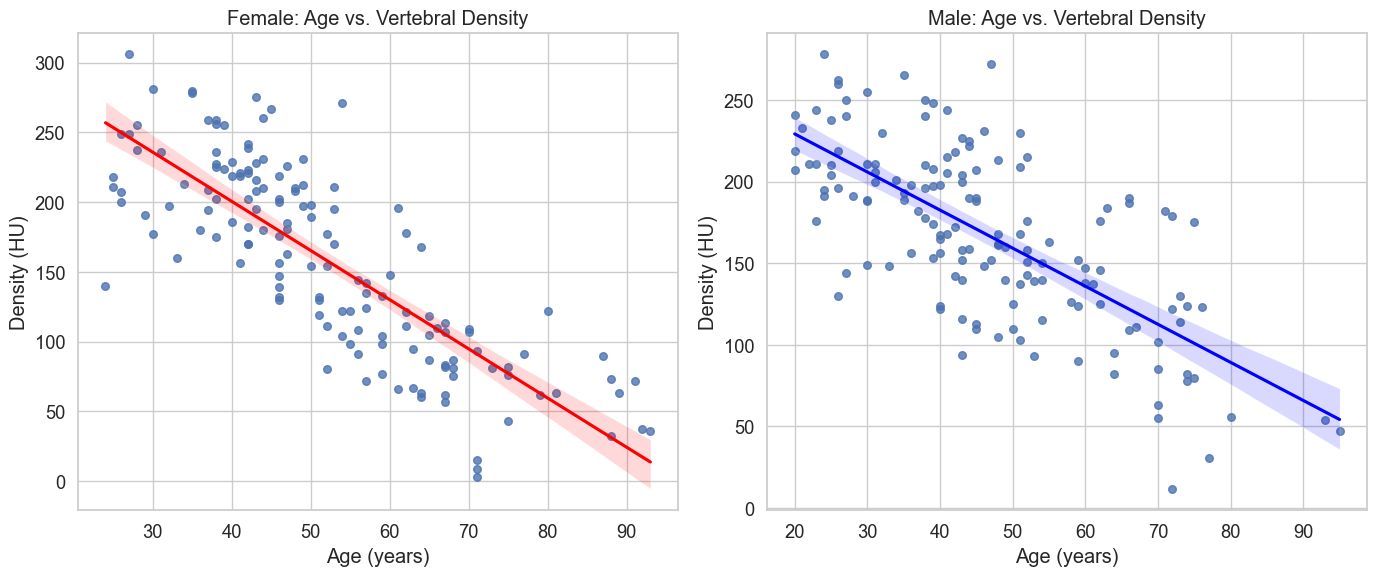

In [ ]:

# Correlation plots to visualize the relationship between age and bone density.
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(14, 6))

# Female
plt.subplot(1, 2, 1)
sns.regplot(x="age", y="density", data=df_female, scatter_kws={"s": 30}, line_kws={"color": "red"})
plt.title("Female: Age vs. Vertebral Density")
plt.xlabel("Age (years)")
plt.ylabel("Density (HU)")

# Male
plt.subplot(1, 2, 2)
sns.regplot(x="age", y="density", data=df_male, scatter_kws={"s": 30}, line_kws={"color": "blue"})
plt.title("Male: Age vs. Vertebral Density")
plt.xlabel("Age (years)")
plt.ylabel("Density (HU)")

plt.tight_layout()
plt.savefig("correlation.png", dpi=300)
plt.show()


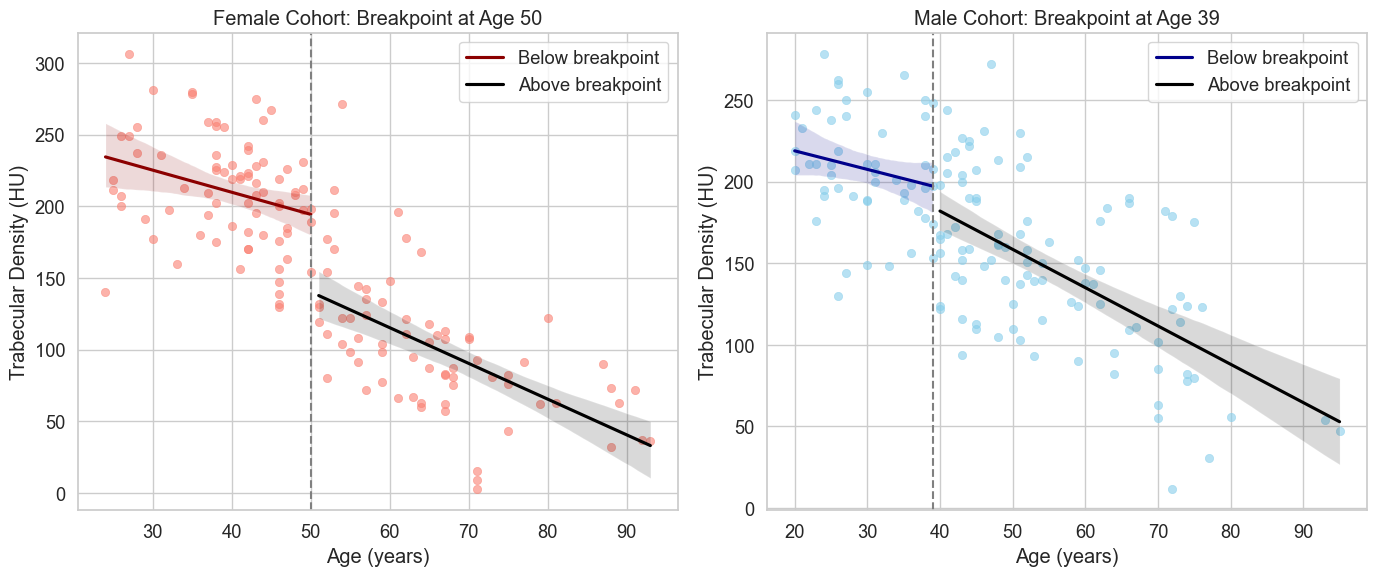

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Breakpoint function working over age
def find_breakpoint(df, min_age=30, max_age=80):
    ages = range(min_age, max_age + 1)
    errors = []

    for breakpoint in ages:
        df_low = df[df["age"] <= breakpoint]
        df_high = df[df["age"] > breakpoint]

        if len(df_low) < 10 or len(df_high) < 10:
            errors.append(float('inf'))
            continue

        X_low = sm.add_constant(df_low["age"])
        X_high = sm.add_constant(df_high["age"])
        y_low = df_low["density"]
        y_high = df_high["density"]

        model_low = sm.OLS(y_low, X_low).fit()
        model_high = sm.OLS(y_high, X_high).fit()

        error = model_low.ssr + model_high.ssr
        errors.append(error)

    best_index = int(errors.index(min(errors)))
    best_age = ages[best_index]
    return best_age, errors[best_index]

# Breakpoints for both cohorts
best_female_age, _ = find_breakpoint(df_female)
best_male_age, _ = find_breakpoint(df_male)

# Create scatter plots with regression lines
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(14, 6))

# Female
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_female, x="age", y="density", alpha=0.6, color="salmon", edgecolor=None)
sns.regplot(data=df_female[df_female["age"] <= best_female_age], x="age", y="density", scatter=False, color="darkred", label="Below breakpoint")
sns.regplot(data=df_female[df_female["age"] > best_female_age], x="age", y="density", scatter=False, color="black", label="Above breakpoint")
plt.axvline(x=best_female_age, color="gray", linestyle="--")
plt.title(f"Female Cohort: Breakpoint at Age {best_female_age}")
plt.xlabel("Age (years)")
plt.ylabel("Trabecular Density (HU)")
plt.legend()

# Male
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_male, x="age", y="density", alpha=0.6, color="skyblue", edgecolor=None)
sns.regplot(data=df_male[df_male["age"] <= best_male_age], x="age", y="density", scatter=False, color="darkblue", label="Below breakpoint")
sns.regplot(data=df_male[df_male["age"] > best_male_age], x="age", y="density", scatter=False, color="black", label="Above breakpoint")
plt.axvline(x=best_male_age, color="gray", linestyle="--")
plt.title(f"Male Cohort: Breakpoint at Age {best_male_age}")
plt.xlabel("Age (years)")
plt.ylabel("Trabecular Density (HU)")
plt.legend()

plt.tight_layout()
plt.savefig("breakpoints_graph.png", dpi=300)
plt.show()


In [ ]:

# Table comparing slope differences and statistical significance
from scipy.stats import linregress, ttest_ind_from_stats
import pandas as pd

def slope_test(df, label):
    under = df[df["age"] < 50]
    over = df[df["age"] >= 50]

    slope_u, _, _, _, stderr_u = linregress(under["age"], under["density"])
    slope_o, _, _, _, stderr_o = linregress(over["age"], over["density"])

    t_stat, p_val = ttest_ind_from_stats(
        mean1=slope_o, std1=stderr_o, nobs1=len(over),
        mean2=slope_u, std2=stderr_u, nobs2=len(under)
    )

    return {
        "Group": label,
        "Slope <50": round(slope_u, 2),
        "Slope ≥50": round(slope_o, 2),
        "Δ Slope": round(slope_o - slope_u, 2),
        "p-value": f"{p_val:.1e}"
    }

# Create table for slopes
slope_table = pd.DataFrame([
    slope_test(df_female, "Female"),
    slope_test(df_male, "Male")
])

slope_table


,Group,Slope <50,Slope ≥50,Δ Slope,p-value
0,Female,-1.42,-2.68,-1.26,5.8e-31
1,Male,-1.99,-2.39,-0.40,3.4e-06


In [ ]:
# logistik regression model for classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Male breakpoint: 39 years for our dataset
df_male['label'] = df_male['age'].apply(lambda x: 1 if x >= 39 else 0)
X_male = df_male[['density']]
y_male = df_male['label']
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_male, y_male, test_size=0.3, random_state=42)
model_male = LogisticRegression()
model_male.fit(X_train_m, y_train_m)
y_pred_m = model_male.predict(X_test_m)
print("Male Classification Report:")
print(classification_report(y_test_m, y_pred_m))
print("Accuracy (Male):", accuracy_score(y_test_m, y_pred_m))

# Female breakpoint: 50 years for our dataset
df_female['label'] = df_female['age'].apply(lambda x: 1 if x >= 50 else 0)
X_female = df_female[['density']]
y_female = df_female['label']
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_female, y_female, test_size=0.3, random_state=42)
model_female = LogisticRegression()
model_female.fit(X_train_f, y_train_f)
y_pred_f = model_female.predict(X_test_f)
print("Female Classification Report:")
print(classification_report(y_test_f, y_pred_f))
print("Accuracy (Female):", accuracy_score(y_test_f, y_pred_f))


Male Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.54      0.64        13
           1       0.83      0.94      0.88        31

    accuracy                           0.82        44
   macro avg       0.80      0.74      0.76        44
weighted avg       0.81      0.82      0.81        44

Accuracy (Male): 0.8181818181818182
Female Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.88        25
           1       0.82      0.90      0.86        20

    accuracy                           0.87        45
   macro avg       0.87      0.87      0.87        45
weighted avg       0.87      0.87      0.87        45

Accuracy (Female): 0.8666666666666667
